<a href="https://colab.research.google.com/github/fudw/satellite-imagery-to-maps/blob/main/satellite_2_maps_pix2pix_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite2Maps
### Automated creation of maps from satellite imagery and aerial sensor data with Pix2Pix
<br/>

In this project, I develop a data pipeline that takes in satellite images and outputs maps using a Pix2Pix model based on [*Image-to-Image Translation with Conditional Adversarial Networks*](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). 

The model will learn to convert satellite images to maps, by training on a public dataset of paired satellite images and maps.

In [1]:
from google.colab import output

# download and unzip data
!gdown --id 1GSNhusWi-GXn4bOkymluer1Un7_YDBc9
!mkdir data
!unzip satellite-2-map-dataset-kaggle.zip -d data
output.clear()
print('Data downloaded!')

Data downloaded!


In [3]:
!pip install wandb

# import libraries
import os
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import seaborn as sns
import wandb

torch.manual_seed(9)

output.clear()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [4]:
wandb.login()

wandb: Currently logged in as: fudw (use `wandb login --relogin` to force relogin)


True

# I. Data Inspection

(1200, 600)


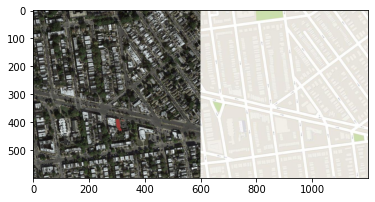

In [5]:
preview = Image.open('/content/data/train/1.jpg')
plt.imshow(preview)
print(preview.size)

In [6]:
train_dir = '/content/data/train'
val_dir = '/content/data/val'
print(f'Train folder has {len(os.listdir(train_dir))} images')
print(f'Val folder has {len(os.listdir(val_dir))} images')

Train folder has 1096 images
Val folder has 1098 images


# II. Build Pix2Pix Model

In [7]:
# Crop image tensor into desired shape
def crop(image, new_shape):
    centre_height = image.shape[2] // 2
    centre_width = image.shape[3] // 2
    start_height = centre_height - new_shape[2] // 2
    end_height = centre_height + new_shape[2] // 2 + new_shape[2] % 2
    start_width = centre_width - new_shape[3] // 2
    end_width = centre_width + new_shape[3] // 2 + new_shape[3] % 2
    cropped_image = image[:, :, start_height:end_height, start_width:end_width]
    return cropped_image

In [8]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock class
    Performs two convolutions followed by a maxpool
    '''

    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels*2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [9]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock class
    Performs an upsampling, a convolution, and a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    '''

    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        #print('shape of x: ', x.shape)
        #print('shape of skip_con_x:', skip_con_x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

In [10]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock class
    Final layer of U-Net
    Maps each pixel to a pixel with correct number of output dimensions
    using 1x1 convolution
    '''

    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [11]:
class UNet(nn.Module):
    '''
    UNet class
    6 contracting blocks followed by 6 expanding blocks, with an upfeature
    layer at the start and a downfeature layer at the end.
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super().__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

In [12]:
class Discriminator(nn.Module):
    '''
    Discriminator class
    Structured like the contracting path of the U-Net, the discriminator
    will output a matrix of values classifying corresponding patches of 
    the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super().__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

## III. Set Up For Training

In [13]:
# Training parameters
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs = 5
input_dim = 3
output_dim = 3
display_step = 200
batch_size = 4
lr = 0.01
target_shape = 512
device = 'cuda'

In [14]:
# Contruct dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((target_shape, target_shape * 2))
                                ])
dataset = torchvision.datasets.ImageFolder('/content/data', transform=transform)

In [15]:
# Initialise weights
def init_weights_random(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.ConvTranspose2d):
        nn.init.normal_(model.weight, 0., 0.2)
    if isinstance(model, nn.BatchNorm2d):
        nn.init.normal_(model.weight, 0., 0.2)
        nn.init.constant_(model.bias, 0)

def init_weights(gen, disc, checkpoint=None):
    if checkpoint is None:
        gen = gen.apply(init_weights_random)
        disc = disc.apply(init_weights_random)
    else:
        loaded_state = torch.load(checkpoint)
        gen.load_state_dict(loaded_state['gen'])
        gen_opt.load_state_dict(loaded_state['gen_opt'])
        disc.load_state_dict(loaded_state['disc'])
        disc_opt.load_state_dict(loaded_state['disc_opt'])
    return gen, disc

In [16]:
# Initialise model
gen = UNet(input_dim, output_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + output_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
gen, disc = init_weights(gen, disc)

In [17]:
# Calculate generator loss
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Returns the loss of the generator.
    Parameters:
        gen: the generator, takes the condition and returns generated image
        disc: the discriminator, takes the condition and the generated image and
          returns the prediction matrix of real/fake
        real: the real image (i.e. the map) to be used to evaluate the reconstruction
        condition: the source image (i.e. the satellite imagery) to be used to generate the map
        adv_criterion: the adversarial loss function, takes the discirminator prediction and 
          the true label and returns an adversarial loss
        recon_criterion: the reconstruction loss function, takes the generated map and the real
          map and returns a reconstruction loss
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    fake = gen(condition)
    pred = disc(fake, condition)
    adv_loss = adv_criterion(pred, torch.ones_like(pred))
    recon_loss = recon_criterion(fake, real)
    gen_loss = adv_loss + lambda_recon * recon_loss
    return gen_loss

In [18]:
# Display image
def show_image(image_tensor, num_images=3, size=(1, 32, 32)):
    image_copy = image_tensor
    image_unflat = image_copy.detach().cpu().view(-1, *size)
    #print(image_unflat.shape)
    #print(image_unflat[:num_images].shape)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    #print(image_grid.shape)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

In [19]:
# Construct grid for image logging
def create_grid(condition, real, fake, num_images=3, size=(1, 32, 32)):
    condition_copy = condition
    real_copy = real
    fake_copy = fake
    condition_unflat = condition_copy.detach().cpu().view(-1, *size)
    real_unflat = real_copy.detach().cpu().view(-1, *size)
    fake_unflat = fake_copy.detach().cpu().view(-1, *size)
    image_grid = [make_grid([condition_unflat[i], real_unflat[i], fake_unflat[i]], nrow=3) for i in range(num_images)]
    #print(image_grid[0].shape)
    grid = torch.cat(image_grid, dim=1)
    #print(type(grid))
    return grid.permute(1, 2, 0).squeeze()

In [20]:
# Plot training losses
def plot_losses(losses):
    gen_loss = losses['gen_loss']
    disc_loss = losses['disc_loss']
    epochs = [*range(len(gen_loss))]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(ax=axes[0], x=epochs, y=gen_loss)
    axes[0].set_title('Generator loss')
    axes[0].set_xlabel('Epochs')
    sns.lineplot(ax=axes[1], x=epochs, y=disc_loss)
    axes[1].set_title('Discriminator loss')
    axes[1].set_xlabel('Epochs')
    imshow()


In [21]:
# Define training loop
def train(save_model=False):
    mean_gen_loss = 0
    mean_disc_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    current_step = 0
    history = {'gen_loss': [],
               'disc_loss': []}
    for epoch in range(n_epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        # Dataloader returns a batch
        for image, _ in tqdm(dataloader):
            if image.shape[0] < batch_size:
                current_step += 1
                break
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)
            current_batch_size = image.shape[0]
            condition = condition.to(device)
            real = real.to(device)

            # Update discriminator
            disc_opt.zero_grad()
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition)  #detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step()

            # Update generator
            gen_opt.zero_grad()
            fake = gen(condition)
            pred = disc(fake, condition)
            adv_loss = adv_criterion(pred, torch.ones_like(pred))
            recon_loss = recon_criterion(fake, real)
            gen_loss = adv_loss + lambda_recon * recon_loss
            gen_loss.backward()
            gen_opt.step()

            # Record average losses
            mean_disc_loss += disc_loss.item() / display_step
            mean_gen_loss += gen_loss.item() / display_step
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            # Visualise at interval
            if current_step % display_step == 0:
                if current_step > 0:
                    print(f'Epoch {epoch} Step {current_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}')
                else:
                    print('Initial state')
                show_image(condition, size=(input_dim, target_shape, target_shape))
                show_image(real, size=(output_dim, target_shape, target_shape))
                show_image(fake, size=(output_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                
            current_step += 1

        if save_model:
            torch.save({'gen' : gen.state_dict(),
                        'gen_opt' : gen_opt.state_dict(),
                        'disc' : disc.state_dict(),
                        'disc_opt' : disc_opt.state_dict(),
                       }, f'sat2maps_{current_step}.pth')    
        
        # Log with wandb
        wandb.log({
           'Epoch': epoch,
           'Generator loss': epoch_gen_loss,
           'Discriminator loss': epoch_disc_loss,
           'Images': wandb.Image(create_grid(condition, real, fake, size=(output_dim, target_shape, target_shape)).numpy())
        })


        # Plot losses vs epochs
        history['disc_loss'].append(epoch_disc_loss)
        history['gen_loss'] .append(epoch_gen_loss)
        plot_losses(history)

        
    #return condition, real, fake


In [ ]:
from torchsummary import summary

In [ ]:
summary(gen, (3, target_shape, target_shape * 2))

In [22]:
wandb.init(project='satellite2maps',
           config={'epochs': n_epochs,
                   'batch_size': batch_size,
                   'lr': lr})

  0%|          | 0/549 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Initial state


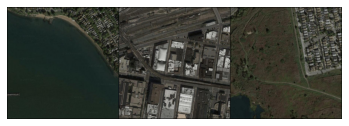

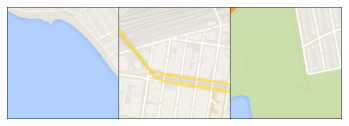

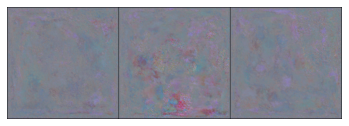

Epoch 0 Step 200: Generator loss: 16.463520188331596, Discriminator loss: 0.3409849372878671


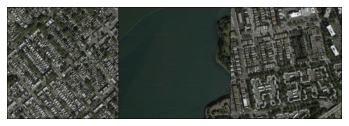

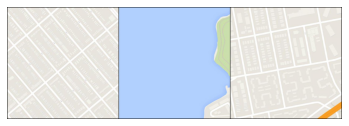

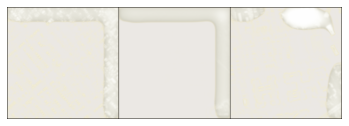

Epoch 0 Step 400: Generator loss: 29.1951964330673, Discriminator loss: 0.8970720807276664


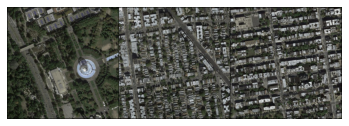

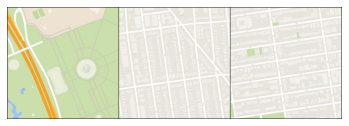

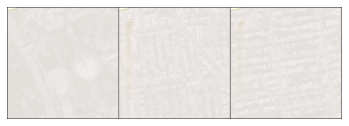

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1 Step 600: Generator loss: 42.73375436782835, Discriminator loss: 1.352340656258167


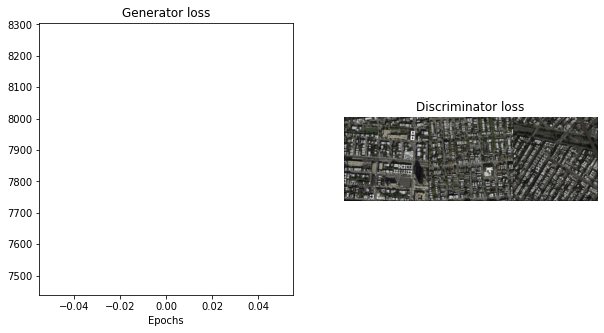

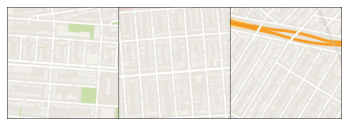

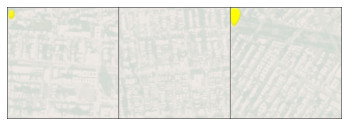

Epoch 1 Step 800: Generator loss: 56.11340144157405, Discriminator loss: 1.6784040594846021


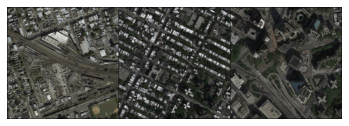

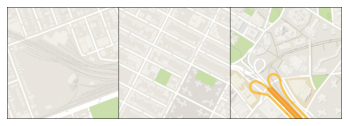

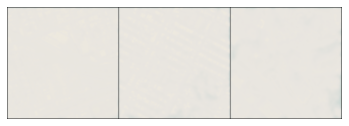

Epoch 1 Step 1000: Generator loss: 70.2015541267395, Discriminator loss: 2.1510535208880923


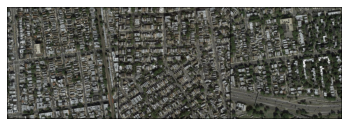

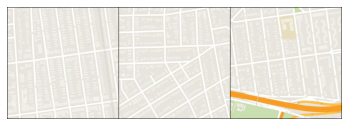

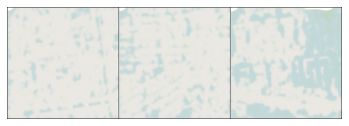

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2 Step 1200: Generator loss: 83.88370716571798, Discriminator loss: 2.4996813586913063


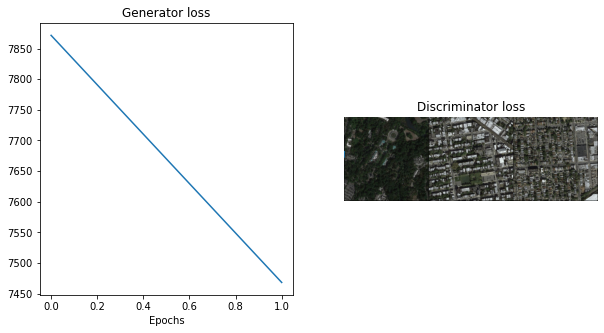

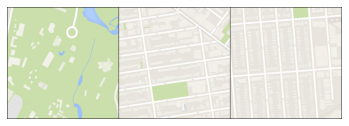

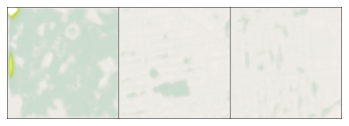

In [ ]:
%%time
train(save_model=True)